<a href="https://colab.research.google.com/github/abihlo/pinnSWE/blob/main/shallowWater2DPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyDOE

In [2]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt 

In [3]:
# Initial condition
u0 = lambda x, y: 0*x
v0 = lambda x, y: 0*y
h0 = lambda x, y: 1+0.5*np.exp(-20*((x-0.0)**2+(y-0.0)**2))

# u0 = lambda x: 0.01*np.sin(np.pi*x+0.5)
# h0 = lambda x: 0.75 + 0.25*np.sin(np.pi*x)

# Boundaries of the computational domain
xleft, xright = -1, 1
ylower, yupper = -1, 1
t0, tfinal = 0, 2

# Gravitational constant
g = tf.constant(1.0, dtype=tf.float32)

(-1.0, 1.0, -1.0, 1.0)

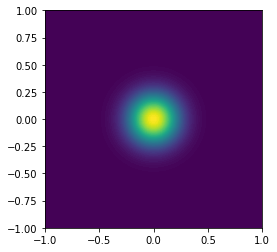

In [4]:
x = np.linspace(xleft, xright, 100)
y = np.linspace(ylower, yupper, 100)
X,Y = np.meshgrid(x,y)
plt.contourf(X, Y, h0(X, Y), 100)
plt.axis('square')

In [5]:
# Define the network
n_units = 128
inp1 = tf.keras.layers.Input(shape=(1,))
inp2 = tf.keras.layers.Input(shape=(1,))
inp3 = tf.keras.layers.Input(shape=(1,))
b = tf.keras.layers.Concatenate()([inp1, inp2, inp3])
for i in range(6):
  b = tf.keras.layers.Dense(n_units, activation='tanh')(b)
out = tf.keras.layers.Dense(3, activation='linear')(b)

model = tf.keras.models.Model([inp1, inp2, inp3], out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3)            0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [6]:
def PNNtrain(t_bdry, x_bdry, y_bdry, u0, v0, h0, epochs=20000, N_pde=40000, N_iv=10000, N_bv=12000):

  # Optimizer to be used
  opt = tf.keras.optimizers.Adam(
    learning_rate=0.1,
    beta_1=0.99,
    epsilon=1e-1)

  # Sample points where to evaluate the PDE
  txy_min = np.array([t_bdry[0], x_bdry[0], y_bdry[0]])
  txy_max = np.array([t_bdry[1], x_bdry[1], y_bdry[1]])  
  pde_points = txy_min + (txy_max - txy_min)*lhs(3, N_pde)
  t_pde = tf.Variable(np.expand_dims(pde_points[:, 0], axis=1)) 
  x_pde = tf.Variable(np.expand_dims(pde_points[:, 1], axis=1))
  y_pde = tf.Variable(np.expand_dims(pde_points[:, 2], axis=1))

  # Sample points where to evaluate the initial values
  xy_init = txy_min[1:] +  (txy_max[1:] - txy_min[1:])*lhs(2, N_iv)
  x_init, y_init = np.expand_dims(xy_init[:,0], axis=1), np.expand_dims(xy_init[:,1], axis=1)
  t_init = np.expand_dims(0*x_init, axis=1)
  u_init, v_init, h_init = u0(x_init, y_init), v0(x_init, y_init), h0(x_init, y_init)

  # Sample points where to evaluate the boundary values
  N_bv = N_bv//4
  t_b = np.random.uniform(t_bdry[0], t_bdry[1], size=N_bv)
  x_b = np.random.uniform(x_bdry[0], x_bdry[1], size=N_bv)
  y_b = np.random.uniform(y_bdry[0], y_bdry[1], size=N_bv)
  t_b = np.expand_dims(np.concatenate((t_b, t_b, t_b, t_b)), axis=1)
  x_b = np.expand_dims(np.concatenate((x_bdry[0]*np.ones(N_bv),
                           x_bdry[1]*np.ones(N_bv), x_b, x_b)), axis=1)
  y_b = np.expand_dims(np.concatenate((y_b, y_b, y_bdry[0]*np.ones(N_bv),
                           y_bdry[1]*np.ones(N_bv))), axis=1)

  # Main training loop
  for i in range(epochs):

    # Outer gradient for tuning network parameters
    with tf.GradientTape() as tape:

      # Inner gradient for derivatives of u wrt x and t
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t_pde)
        tape2.watch(x_pde)
        tape2.watch(y_pde)
        uvh = model([t_pde, x_pde, y_pde])
        u, v, h = uvh[:,:1], uvh[:,1:2], uvh[:,2:] 
      [dudt, dudx, dudy] = tape2.gradient(u, [t_pde, x_pde, y_pde])
      [dvdt, dvdx, dvdy] = tape2.gradient(v, [t_pde, x_pde, y_pde])
      [dhdt, dhdx, dhdy] = tape2.gradient(h, [t_pde, x_pde, y_pde])
      
      # Solve the shallow-water equations
      dudt, dudx, dudy = tf.cast(dudt, tf.float32), tf.cast(dudx, tf.float32), tf.cast(dudy, tf.float32)
      dvdt, dvdx, dvdy = tf.cast(dvdt, tf.float32), tf.cast(dvdx, tf.float32), tf.cast(dvdy, tf.float32)
      dhdt, dhdx, dhdy = tf.cast(dhdt, tf.float32), tf.cast(dhdx, tf.float32), tf.cast(dhdy, tf.float32)
      
      eqnu = dudt+u*dudx+v*dudy+g*dhdx
      eqnv = dvdt+u*dvdx+v*dvdy+g*dhdy
      eqnh = dhdt+u*dhdx+v*dhdy+h*(dudx+dvdy)

      # Define the PDE loss  
      PDEloss = tf.reduce_mean(tf.square(eqnu)) + tf.reduce_mean(tf.square(eqnv)) + tf.reduce_mean(tf.square(eqnh))

      # Define the initial and boundary value losses
      uvh_init_pred = model([t_init, x_init, y_init])
      u_init_pred, v_init_pred, h_init_pred = uvh_init_pred[:,:1], uvh_init_pred[:,1:2], uvh_init_pred[:,2:] 
      IVloss = tf.reduce_mean(tf.square(u_init-u_init_pred)) + tf.reduce_mean(tf.square(v_init-v_init_pred)) + tf.reduce_mean(tf.square(h_init-h_init_pred))
                              
      uvh_b = model([t_b, x_b, y_b])
      u_b, v_b, h_b = uvh_b[:,:1], uvh_b[:,1:2], uvh_b[:,2:]
      BVloss = tf.reduce_mean(tf.square(u_b[:N_bv]-u_b[N_bv:2*N_bv])) + tf.reduce_mean(tf.square(u_b[2*N_bv:3*N_bv]-u_b[3*N_bv:4*N_bv])) +  tf.reduce_mean(tf.square(v_b[:N_bv]-v_b[N_bv:2*N_bv])) + tf.reduce_mean(tf.square(v_b[2*N_bv:3*N_bv]-v_b[3*N_bv:4*N_bv])) + tf.reduce_mean(tf.square(h_b[:N_bv]-h_b[N_bv:2*N_bv])) + tf.reduce_mean(tf.square(h_b[2*N_bv:3*N_bv]-h_b[3*N_bv:4*N_bv]))
      # BVloss = tf.reduce_mean(tf.square(u_b[:N_bv]-u_b[N_bv:2*N_bv])) + tf.reduce_mean(tf.square(v_b[2*N_bv:3*N_bv]-v_b[3*N_bv:4*N_bv])) + tf.reduce_mean(tf.square(h_b[:N_bv]-h_b[N_bv:2*N_bv])) + tf.reduce_mean(tf.square(h_b[2*N_bv:3*N_bv]-h_b[3*N_bv:4*N_bv]))


      # Global loss
      loss = PDEloss + IVloss + BVloss

    # Compute the gradient of the global loss wrt the model parameters
    grads = tape.gradient(loss, model.trainable_variables)

    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))

    if (np.mod(i, 100)==0):
      print("Total loss, PDE loss, IV loss, BV loss in {}th epoch: {: 6.4f}, {: 6.4f}, {: 6.4f}, {: 6.4f}.".format(i, loss.numpy(), PDEloss.numpy(),
                                                                              IVloss.numpy(), BVloss.numpy()))

In [7]:
PNNtrain([t0, tfinal], [xleft, xright], [ylower, yupper], u0, v0, h0)

Total loss, PDE loss, IV loss, BV loss in 0th epoch:  1.5424,  0.0751,  1.0837,  0.3837.
Total loss, PDE loss, IV loss, BV loss in 100th epoch:  0.1161,  0.0022,  0.1125,  0.0015.
Total loss, PDE loss, IV loss, BV loss in 200th epoch:  0.0165,  0.0001,  0.0161,  0.0003.
Total loss, PDE loss, IV loss, BV loss in 300th epoch:  0.0049,  0.0001,  0.0048,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 400th epoch:  0.0055,  0.0001,  0.0053,  0.0001.
Total loss, PDE loss, IV loss, BV loss in 500th epoch:  0.0062,  0.0001,  0.0061,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 600th epoch:  0.0049,  0.0001,  0.0049,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 700th epoch:  0.0046,  0.0001,  0.0045,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 800th epoch:  0.0043,  0.0001,  0.0043,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 900th epoch:  0.0043,  0.0001,  0.0043,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 1000th epoch:  0.0043,  0.0001,  0.0042,  0.0000.


In [8]:
# Grid where to evaluate the model
l, m, n = 20, 500, 500
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
y = np.linspace(ylower, yupper, n)
T, X, Y  = np.meshgrid(t, x, y, indexing='ij')

dt = t[1]-t[0]

uvh = model([np.expand_dims(T.flatten(), axis=1), 
           np.expand_dims(X.flatten(), axis=1),
           np.expand_dims(Y.flatten(), axis=1)])
u, v, h = np.reshape(uvh[:,:1], (l, m, n)), np.reshape(uvh[:,1:2], (l, m, n)), np.reshape(uvh[:,2:], (l, m, n)) 

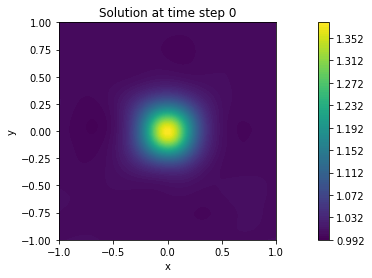

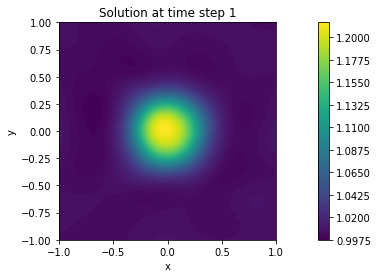

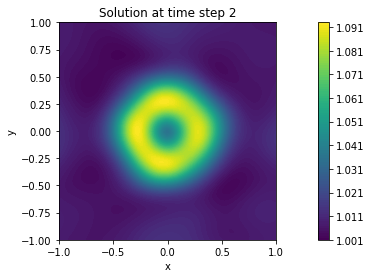

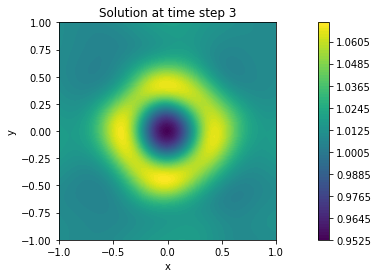

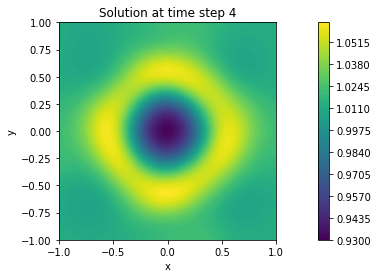

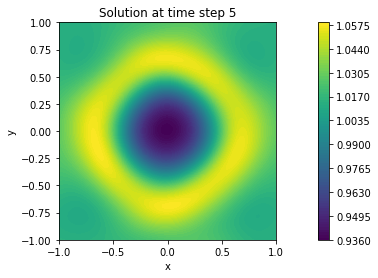

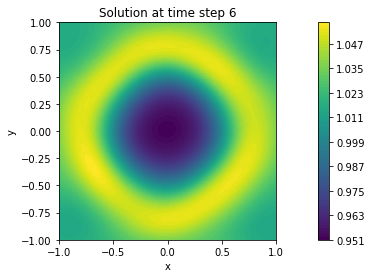

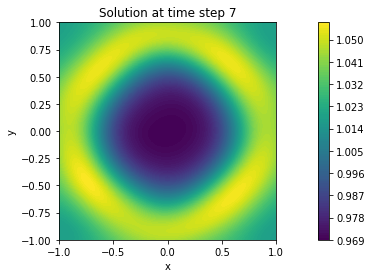

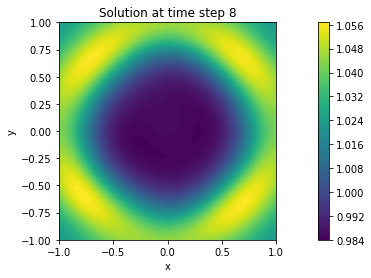

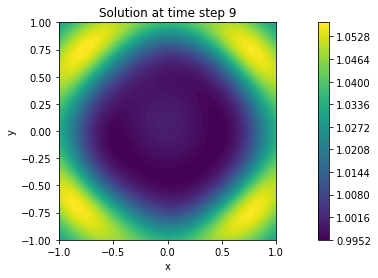

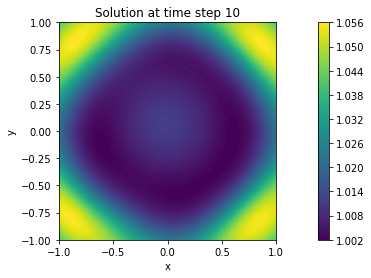

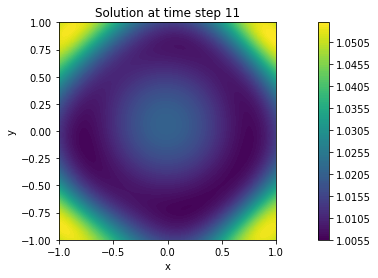

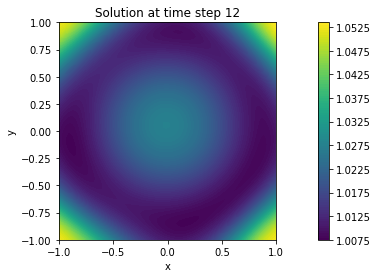

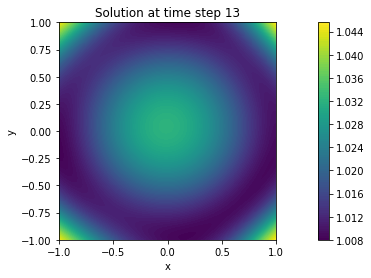

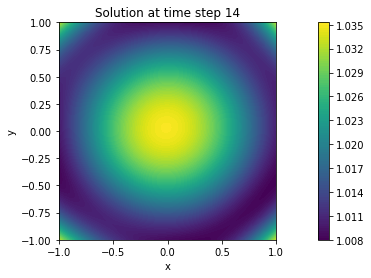

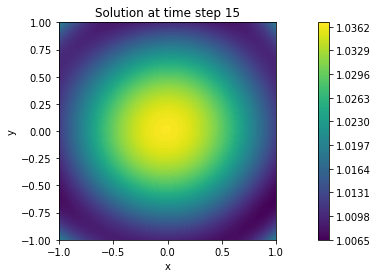

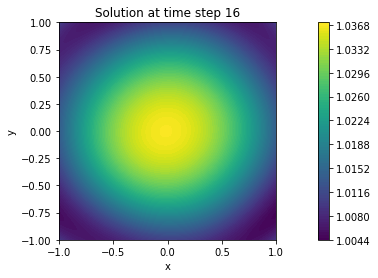

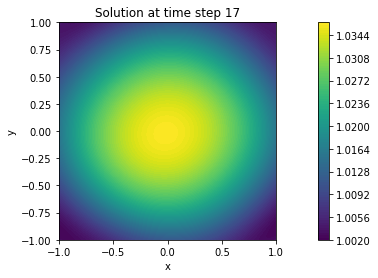

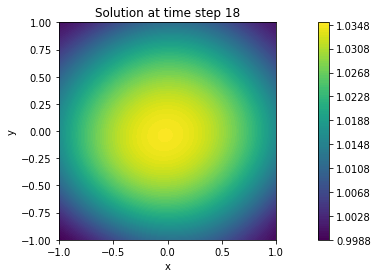

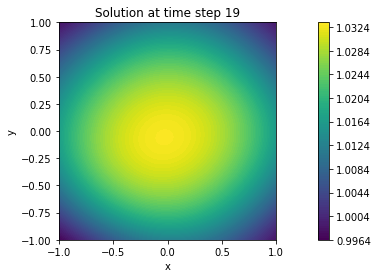

In [9]:
plot_steps = [i for i in range(20)]
for i in plot_steps:
  plt.contourf(X[i,], Y[i,], h[i, :, :], 100)
  plt.colorbar()
  plt.axis('square')
  plt.title('Solution at time step {}'.format(i))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()